In [1]:
!pip install tensorflow  mediapipe matplotlib 
    

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp


2024-08-14 11:18:08.684342: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-14 11:18:10.417542: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-14 11:18:10.420876: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 11:18:12.734854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
colors = [(245,117,16), (117,245,16), (16,117,245), (16,117,245), (16,117,245), (16,117,245), (16,117,245), (16,117,245), (16,117,245), (16,117,245)]
def prob_viz (res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [6]:
def draw_styled_landmarks (image, results):
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR )
    image.flags.wrietable = False
    results = model.process(image)
    image.flags.wrietble = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image,results

In [7]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [8]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

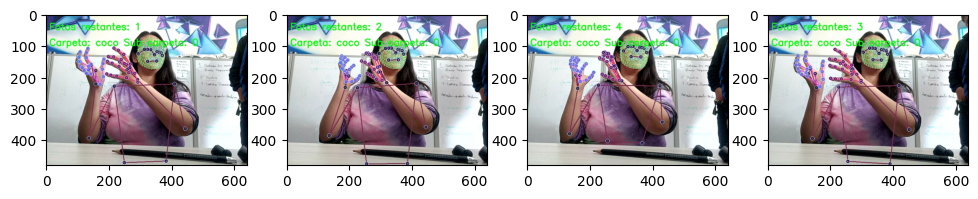

In [9]:
#Mostrar algunas imagenes con pyplot
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

carpeta = '/home/fabrica/anaconda3/envs/linkproject_ia/JUst_phot/coco'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

Found 4 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


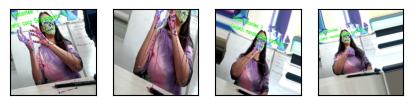

In [30]:
#Aumento de datos con ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    validation_split=0.5 #20% para pruebas
)


#Generadores para sets de entrenamiento y pruebas
data_gen_entrenamiento = datagen.flow_from_directory('/home/fabrica/anaconda3/envs/linkproject_ia/JUst_phot', target_size=(224,224,),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory('/home/fabrica/anaconda3/envs/linkproject_ia/JUst_phot', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

#Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(4):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()


In [31]:
import tensorflow as tf
import tensorflow_hub as hub

# Cargar MobileNetV2 desde TensorFlow Hub
mobilenetv2 = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
    input_shape=(224, 224, 3 ),  # Tamaño de la imagen de entrada
    trainable=False  # Esto indica si se entrenarán los pesos de MobileNetV2 o no
)

In [32]:
#Congelar el modelo descargado
mobilenetv2.trainable = False

In [33]:
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(3, activation='softmax')
])

In [34]:
modelo.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [35]:
#Compilar como siempre
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
#Entrenar el modelo
EPOCAS = 50

historial = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_50260/1876796780.py", line 4, in <module>
      historial = modelo.fit(
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/keras/src/engine/training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/keras/src/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/keras/src/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/home/fabrica/anaconda3/envs/preModel/lib/python3.8/site-packages/keras/src/backend.py", line 5566, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[4,3] labels_size=[4,2]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_61462]

In [37]:
import os

base_dir = '/home/fabrica/anaconda3/envs/linkproject_ia/JUst_phot'
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):
        print(f"Clase: {class_name}, Número de imágenes: {len(os.listdir(class_dir))}")


Clase: coco, Número de imágenes: 4
Clase: Manzana, Número de imágenes: 4
